In [31]:
import pandas as pd
from bs4 import BeautifulSoup
from nltk.tokenize import sent_tokenize, word_tokenize
import gensim
from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
import re
import unicodedata as ud
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import unicodedata
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

In [2]:
import pandas as pd

df_ann = pd.read_csv('./annotated_pagos/areiospagos_annotated.csv')

In [3]:
df_ann['Label'].value_counts()

Label
1    2450
0     550
Name: count, dtype: int64

Creating a new balanced dataset to work with for Areios Pagos


In [4]:
df_0 = df_ann[df_ann['Label'] == 0]
df_1 = df_ann[df_ann['Label'] == 1]

df_0_sample = df_0.sample(500)
df_1_sample = df_1.sample(750)

df_resampled_ap = pd.concat([df_0_sample, df_1_sample])

# Shuffle the dataset
df_resampled_ap = df_resampled_ap.sample(frac=1).reset_index(drop=True)

# Check the distribution of labels
df_resampled_ap['Label'].value_counts()


Label
1    750
0    500
Name: count, dtype: int64

In [5]:
df_resampled_ap

,Decision,Label
0,Decision_420,1
1,Decision_1797,1
2,Decision_2171,0
3,Decision_819,0
4,Decision_2741,1
...,...,...
1245,Decision_1240,1
1246,Decision_954,1
1247,Decision_2400,1
1248,Decision_1664,0


In [6]:


def preprocess_text(file_path):
    with open(file_path, 'r') as file:
        # Read the text from the file
        text = file.read()
        # Convert to lowercase
        text = text.lower()
        # Remove accents
        text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
        # Remove punctuations
        text = re.sub(r'[^\w\s]', '', text)
        # Remove numbers
        text = re.sub(r'\d+', '', text)
        # Remove English characters
        text = re.sub(r'[a-zA-Z]', '', text)
        # Remove all special chars
        text = text.replace('_', '')
        # Transforn to list of words
        text = text.replace('\n', ' ').split(' ')
    return text
stop_words = preprocess_text('stopwords.txt')



In [7]:
print(df_ann.columns)

Index(['Decision', 'Label'], dtype='object')


In [8]:
df = pd.read_csv('areiospagos_annotation/areiospagos_annottated.csv')


In [9]:
print(df.columns)

Index(['Decision', 'Label'], dtype='object')


In [10]:
df


,Decision,Label
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1
...,...,...
2995,ΑΡΙΘΜΟΣ 350/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2996,Αριθμός 354/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2997,Αριθμός 332/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1
2998,ΑΡΙΘΜΟΣ 328/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1


In [11]:


def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove accents
    text = ''.join(char for char in unicodedata.normalize('NFKD', text) if not unicodedata.combining(char))
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove English characters
    text = re.sub(r'[a-zA-Z]', '', text)
    # Remove all special chars
    text = text.replace('_', '')
    # Transforn to list of words
    text = text.replace('\n', ' ').split(' ')
    return text



In [12]:

df['processed_text'] = df['Decision'].apply(preprocess_text)


In [13]:
df.head()

,Decision,Label,processed_text
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,"[αριθμος, , , , το, δικαστηριο, του, αρειου, π..."


In [14]:
df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))

In [15]:
df

,Decision,Label,processed_text
0,ΑΡΙΘΜΟΣ 970/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου πο...
1,Αριθμός 1692/2009 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,0,αριθμος το δικαστηριο του αρειου παγου πο...
2,Αριθμός 92/2013 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ Π...,1,αριθμος το δικαστηριο του αρειου παγου ζ π...
3,Αριθμός 1502/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,αριθμος το δικαστηριο του αρειου παγου πο...
4,Αριθμός 1501/2018 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ...,1,αριθμος το δικαστηριο του αρειου παγου ζπο...
...,...,...,...
2995,ΑΡΙΘΜΟΣ 350/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου α π...
2996,Αριθμός 354/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου στ...
2997,Αριθμός 332/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου ε ...
2998,ΑΡΙΘΜΟΣ 328/2011 \n\nΤΟ ΔΙΚΑΣΤΗΡΙΟ ΤΟΥ ΑΡΕΙΟΥ ...,1,αριθμος το δικαστηριο του αρειου παγου ε π...


In [17]:
df.drop('Decision', axis=1, inplace=True)


In [19]:
df.to_csv('final_ap_df.csv', index=False)


In [21]:
df = pd.read_csv('final_with_cut_ap_df.csv')

## TF-IDF VECTORIZER ##
TF-IDF Vectorization:

It uses TfidfVectorizer from scikit-learn to convert the text data (df_resampled['script']) into a matrix of TF-IDF features.
The parameters used in TfidfVectorizer are:

norm='l2': This normalizes the vectors to have an L2 norm (unit norm).

stop_words=stop_words: This removes common stop words (as defined by the stop_words variable) from the text before vectorizing.

max_features=5000: Limits the vocabulary to the 5000 most frequent terms.

Transformation:

The fit_transform method is applied to the text data (df_resampled['script']), which learns the vocabulary and IDF (Inverse Document Frequency) values from the data, and then transforms the text data into a TF-IDF weighted term-document matrix.
This matrix is then converted into a dense array using .toarray().

Creating a DataFrame:

The TF-IDF matrix is then converted into a Pandas DataFrame (data_resampled), with the same index as the original DataFrame (df_resampled.index) and with columns named after the terms in the vocabulary (tfidf.get_feature_names_out()).
Appending the Label:

The 'Label' column from the original df_resampled DataFrame is added to the data_resampled DataFrame, aligning by index.





In [23]:

# Initialize TfidfVectorizer with your stop words and set max_features
tfidf = TfidfVectorizer(norm='l2', stop_words=stop_words, max_features=100)

# Apply the TF-IDF transformation on the 'script' column (or rename if necessary)
tfidf_matrix = tfidf.fit_transform(df['processed_text']).toarray()

# Create a new DataFrame with TF-IDF features and add the 'Label' column
df_tfidf = pd.DataFrame(tfidf_matrix, index=df.index, columns=tfidf.get_feature_names_out())
df_tfidf['Label'] = df['Label'].values


In [24]:
df_tfidf


,αγωγη,αγωγης,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντος,αναιρεσειων,αναιρεσεως,...,προσβαλλομενη,στοιχ,στοιχεια,συζητηση,συμφωνα,τμημα,τροπο,υπαρχει,χρονο,Label
0,0.000000,0.000000,0.010388,0.006579,0.033908,0.000000,0.055103,0.040483,0.019570,0.076910,...,0.057499,0.047453,0.115184,0.009187,0.045793,0.006544,0.071192,0.087195,0.021390,1
1,0.000000,0.000000,0.000000,0.059403,0.051028,0.000000,0.000000,0.000000,0.044175,0.138889,...,0.111252,0.160675,0.000000,0.041476,0.029534,0.029544,0.000000,0.043739,0.000000,0
2,0.000000,0.000000,0.042510,0.107692,0.115635,0.000000,0.169122,0.103543,0.100105,0.283264,...,0.084036,0.169917,0.000000,0.075192,0.080312,0.013390,0.041620,0.019824,0.000000,1
3,0.197009,0.023121,0.430706,0.028415,0.016272,0.000000,0.002644,0.000000,0.002817,0.026574,...,0.026016,0.310843,0.018090,0.010581,0.013185,0.011305,0.005857,0.025107,0.021557,1
4,0.000000,0.000000,0.131010,0.033189,0.099785,0.000000,0.046330,0.051057,0.049362,0.067899,...,0.041438,0.089771,0.039619,0.023173,0.033002,0.008253,0.102614,0.073313,0.013489,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.549863,0.204351,0.095168,0.200912,0.000000,0.126902,0.028046,0.030907,0.000000,0.281846,...,0.050169,0.000000,0.095933,0.056112,0.139844,0.019984,0.031059,0.000000,0.032661,1
2996,0.000000,0.000000,0.000000,0.096248,0.124016,0.000000,0.000000,0.000000,0.000000,0.140646,...,0.060085,0.130166,0.038298,0.000000,0.143556,0.023934,0.037197,0.070868,0.000000,1
2997,0.000000,0.000000,0.000000,0.302083,0.000000,0.000000,0.168675,0.092942,0.269569,0.000000,...,0.000000,0.000000,0.000000,0.084368,0.120150,0.060095,0.000000,0.000000,0.000000,1
2998,0.000000,0.000000,0.635206,0.167625,0.000000,0.000000,0.000000,0.051573,0.049861,0.078383,...,0.000000,0.000000,0.000000,0.000000,0.033336,0.033347,0.000000,0.000000,0.000000,1


In [25]:
df_tfidf


,αγωγη,αγωγης,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντος,αναιρεσειων,αναιρεσεως,...,προσβαλλομενη,στοιχ,στοιχεια,συζητηση,συμφωνα,τμημα,τροπο,υπαρχει,χρονο,Label
0,0.000000,0.000000,0.010388,0.006579,0.033908,0.000000,0.055103,0.040483,0.019570,0.076910,...,0.057499,0.047453,0.115184,0.009187,0.045793,0.006544,0.071192,0.087195,0.021390,1
1,0.000000,0.000000,0.000000,0.059403,0.051028,0.000000,0.000000,0.000000,0.044175,0.138889,...,0.111252,0.160675,0.000000,0.041476,0.029534,0.029544,0.000000,0.043739,0.000000,0
2,0.000000,0.000000,0.042510,0.107692,0.115635,0.000000,0.169122,0.103543,0.100105,0.283264,...,0.084036,0.169917,0.000000,0.075192,0.080312,0.013390,0.041620,0.019824,0.000000,1
3,0.197009,0.023121,0.430706,0.028415,0.016272,0.000000,0.002644,0.000000,0.002817,0.026574,...,0.026016,0.310843,0.018090,0.010581,0.013185,0.011305,0.005857,0.025107,0.021557,1
4,0.000000,0.000000,0.131010,0.033189,0.099785,0.000000,0.046330,0.051057,0.049362,0.067899,...,0.041438,0.089771,0.039619,0.023173,0.033002,0.008253,0.102614,0.073313,0.013489,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,0.549863,0.204351,0.095168,0.200912,0.000000,0.126902,0.028046,0.030907,0.000000,0.281846,...,0.050169,0.000000,0.095933,0.056112,0.139844,0.019984,0.031059,0.000000,0.032661,1
2996,0.000000,0.000000,0.000000,0.096248,0.124016,0.000000,0.000000,0.000000,0.000000,0.140646,...,0.060085,0.130166,0.038298,0.000000,0.143556,0.023934,0.037197,0.070868,0.000000,1
2997,0.000000,0.000000,0.000000,0.302083,0.000000,0.000000,0.168675,0.092942,0.269569,0.000000,...,0.000000,0.000000,0.000000,0.084368,0.120150,0.060095,0.000000,0.000000,0.000000,1
2998,0.000000,0.000000,0.635206,0.167625,0.000000,0.000000,0.000000,0.051573,0.049861,0.078383,...,0.000000,0.000000,0.000000,0.000000,0.033336,0.033347,0.000000,0.000000,0.000000,1


In [26]:
df_tfidf['Label'] = df_tfidf['Label'].values

df_0 = df_tfidf[df_tfidf['Label'] == 0]
df_1 = df_tfidf[df_tfidf['Label'] == 1]

df_0_sample = df_0.sample(500)
df_1_sample = df_1.sample(750)

df_resampled = pd.concat([df_0_sample, df_1_sample])
df_resampled['Label'].value_counts()

Label
1    750
0    500
Name: count, dtype: int64

In [27]:
import pandas as pd

# Assuming 'resampled_df' is your resampled dataset (a DataFrame)
memory_usage_bytes = df_resampled.memory_usage(deep=True).sum()

# Convert bytes to megabytes
memory_usage_mb = memory_usage_bytes / (1024 * 1024)

print(f"Estimated memory usage: {memory_usage_mb:.2f} MB")

Estimated memory usage: 0.97 MB


In [28]:
df_resampled

,αγωγη,αγωγης,αθηνων,αιτηση,αιτιολογια,ακ,ακροατηριο,αναιρεσειοντος,αναιρεσειων,αναιρεσεως,...,προσβαλλομενη,στοιχ,στοιχεια,συζητηση,συμφωνα,τμημα,τροπο,υπαρχει,χρονο,Label
1353,0.166755,0.037184,0.000000,0.036558,0.000000,0.076970,0.000000,0.000000,0.000000,0.021369,...,0.068466,0.000000,0.029093,0.025525,0.145405,0.018182,0.000000,0.000000,0.089146,0
2556,0.129994,0.144933,0.281237,0.035623,0.000000,0.000000,0.000000,0.000000,0.000000,0.041645,...,0.222387,0.000000,0.000000,0.149238,0.106267,0.035434,0.000000,0.000000,0.057912,0
1330,0.045165,0.000000,0.000000,0.024754,0.000000,0.000000,0.207331,0.000000,0.000000,0.086815,...,0.123626,0.000000,0.000000,0.241973,0.049229,0.049245,0.000000,0.000000,0.000000,0
2331,0.000000,0.000000,0.000000,0.055425,0.000000,0.000000,0.025790,0.000000,0.000000,0.086392,...,0.069201,0.133258,0.000000,0.180594,0.110224,0.018377,0.000000,0.000000,0.000000,0
2238,0.000000,0.000000,0.000000,0.156990,0.000000,0.000000,0.146099,0.080502,0.077829,0.122351,...,0.130673,0.188724,0.000000,0.073075,0.104069,0.052052,0.000000,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2268,0.063370,0.176630,0.164517,0.086829,0.089504,0.146250,0.048483,0.133574,0.103311,0.162409,...,0.086727,0.187885,0.082919,0.024250,0.086338,0.017273,0.080536,0.076720,0.084693,1
2136,0.082584,0.138112,0.142934,0.045263,0.000000,0.095297,0.000000,0.069630,0.100977,0.052913,...,0.028256,0.000000,0.000000,0.031603,0.112517,0.022511,0.104956,0.033327,0.110373,1
744,0.051107,0.014245,0.000000,0.021008,0.000000,0.088462,0.019551,0.032318,0.041660,0.008186,...,0.017486,0.000000,0.022291,0.068452,0.083558,0.006965,0.064952,0.030937,0.079688,1
1306,0.000000,0.000000,0.000000,0.088478,0.190009,0.000000,0.000000,0.068056,0.131592,0.103434,...,0.110469,0.119659,0.105618,0.000000,0.131968,0.022002,0.034194,0.065148,0.071918,1


## Classifiers

## 1. Random Forest ##

Train shape: (837, 100) | Test shape: (413, 100)


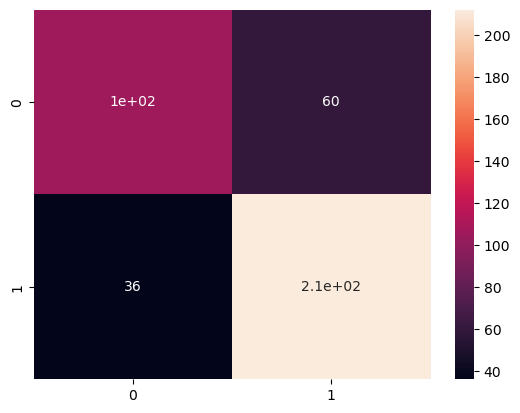

Accuracy: 0.7675544794188862
F1: 0.8153846153846154


In [29]:


X = df_resampled.drop('Label', axis=1)
y = df_resampled['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)
print(f'Train shape: {X_train.shape} | Test shape: {X_test.shape}')

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Confusion matrix
y_pred = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

print(f'Accuracy: {rf.score(X_test, y_test)}')

# Calculate MCC
from sklearn.metrics import matthews_corrcoef, f1_score

f1 = f1_score(y_test, y_pred)
print(f'F1: {f1}')

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5; 1/25] START bootstrap=True, max_depth=23, max_features=0.36363636363636365, min_samples_leaf=1, min_samples_split=6, n_estimators=102
[CV 2/5; 1/25] START bootstrap=True, max_depth=23, max_features=0.36363636363636365, min_samples_leaf=1, min_samples_split=6, n_estimators=102
[CV 3/5; 1/25] START bootstrap=True, max_depth=23, max_features=0.36363636363636365, min_samples_leaf=1, min_samples_split=6, n_estimators=102
[CV 4/5; 1/25] START bootstrap=True, max_depth=23, max_features=0.36363636363636365, min_samples_leaf=1, min_samples_split=6, n_estimators=102
[CV 5/5; 1/25] START bootstrap=True, max_depth=23, max_features=0.36363636363636365, min_samples_leaf=1, min_samples_split=6, n_estimators=102
[CV 1/5; 2/25] START bootstrap=False, max_depth=9, max_features=0.9636363636363636, min_samples_leaf=4, min_samples_split=6, n_estimators=5
[CV 2/5; 2/25] START bootstrap=False, max_depth=9, max_features=0.9636363636363636,

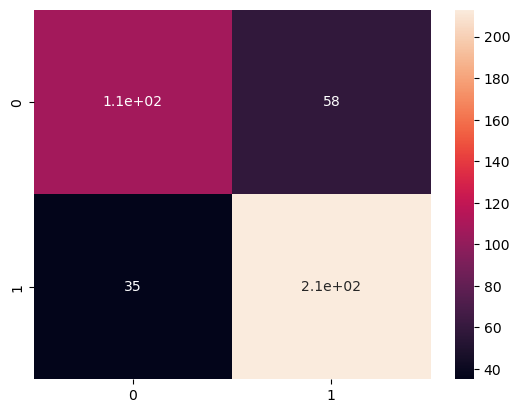

Precision: 0.7860
Recall: 0.8589
Accuracy: 0.774818401937046
MCC: 0.5231806080782228
F1: 0.8208092485549133


In [37]:
from re import search
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [5, 10, 15, 20, 25, 30, 50, 80, 100, 200, 300],           # Number of trees in the forest
    'max_depth': [None, 2, 4, 6, 8, 12, 20, 30],           # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': ['auto', 'sqrt', 'log2']   # Number of features to consider when looking for the best split
}

param_dist = {
    'n_estimators': np.linspace(5, 200, 5, dtype=int),           # Number of trees in the forest
    'max_depth': np.linspace(2, 30, 5, dtype=int),           # Maximum depth of the tree
    'min_samples_split': np.linspace(2, 10, 3, dtype=int),           # Minimum number of samples required to split a node
    'min_samples_leaf': np.linspace(1, 4, 3, dtype=int),             # Minimum number of samples required at a leaf node
    'bootstrap': [True, False],                # Whether bootstrap samples are used when building trees
    'max_features': np.linspace(0.1, 1.0, 100)   # Number of features to consider when looking for the best split
}

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Set up RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist, n_iter=25, cv=5, verbose=20, n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = grid_search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Best hyperparameters
print("Best hyperparameters found: ", grid_search.best_params_)

# Best estimator (RandomForest with best hyperparameters)
best_rf = grid_search.best_estimator_

# Predict using the best model
y_pred = best_rf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True)
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Calculate F1 score (MCC-like)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1}')


## 2. XGBoost Regression

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.5, gamma=0.2, learning_rate=0.16263157894736843, max_depth=9, min_child_weight=3, n_estimators=700, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=   0.8s
[CV] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.3, max_depth=8, min_child_weight=1, n_estimators=1000, subsample=0.6; total time=   

/Users/thodorismexis/anaconda3/envs/decisions/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.04052631578947368, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.04052631578947368, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.04052631578947368, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.04052631578947368, max_depth=9, min_child_weight=5, n_estimators=100, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.02526315789473684, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=1.0, gamma=0.2, learning_rate=0.02526315789473684, max_depth=10, min_child_weight=2, n_estimators=200, subsample=1.0; total time=   1.4s
[CV] END colsample_bytree=

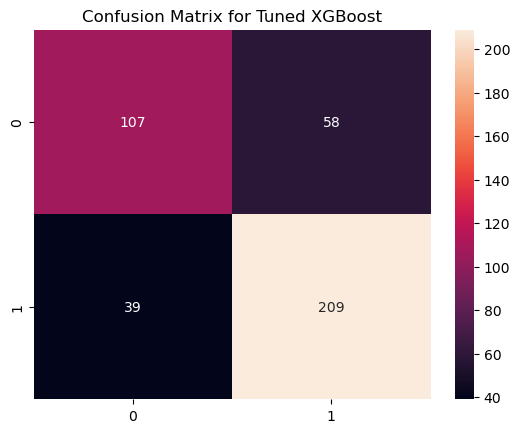

Precision: 0.7828
Recall: 0.8427
Accuracy: 0.7651331719128329
MCC: 0.5032894102597294
F1: 0.8116504854368932


In [35]:
from xgboost import XGBClassifier

# Define parameter distribution for RandomizedSearchCV
param_dist = {
    'n_estimators': np.linspace(100, 1000, 10, dtype=int),
    'max_depth': np.linspace(3, 10, 8, dtype=int),
    'learning_rate': np.linspace(0.01, 0.3, 20),
    'subsample': np.linspace(0.5, 1.0, 6),
    'colsample_bytree': np.linspace(0.5, 1.0, 6),
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Initialize XGBoost classifier
xgb = XGBClassifier(random_state=42)

# Set up RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Fit the model
search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", search.best_params_)


# Use best model to predict
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Tuned XGBoost')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'Accuracy: {acc}')
print(f'MCC: {mcc}')
print(f'F1: {f1}')



## 3. SVM

Fitting 5 folds for each of 1200 candidates, totalling 6000 fits
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ...................C=0.01, gamma=0.0, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, gamma=0.010101010101010102, kernel=linear; total time=   0.0s
[CV] END ......................C=0.01, gamma=0.0, kernel=rbf; total time=   0.0s
[CV] END ..C=0.01, gamma=0.01010101010101010

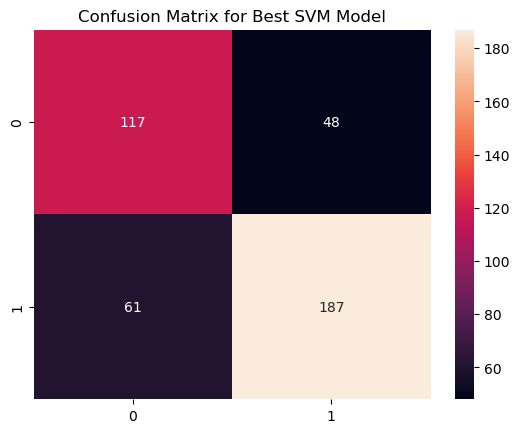

Precision: 0.7957
Recall: 0.7540
Accuracy: 0.7360774818401937
F1 Score: 0.7743271221532091


In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC  # Import the SVM classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Step 3: Set up the SVM classifier and the parameter grid for GridSearchCV
svm = SVC()

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.01,0.1, 0.5, 1, 10, 100],               # Regularization parameter
    'gamma': np.linspace(0, 1, 100),  # Kernel coefficient
    'kernel': ['linear', 'rbf']            # Kernel types
}
    

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = grid_search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Step 6: Get the best estimator and print the best parameters
best_svm = grid_search.best_estimator_
print(f'Best parameters: {grid_search.best_params_}')
print("Best cross-validation score:", grid_search.best_score_)

# Step 7: Use the best model to predict on the test data
y_pred = best_svm.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best SVM Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_svm.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')


## 4. Logistic Regression

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l1, solver=saga; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ..............C=0.001, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2, solver=saga; total time=   0.0s
[CV] END ...................C=0.001, penalty=l2

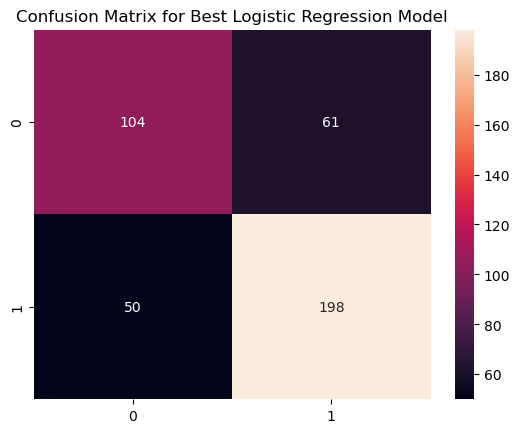

Precision: 0.7645
Recall: 0.7984
Accuracy: 0.7312348668280871
F1 Score: 0.7810650887573964


In [45]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 3: Set up the Logistic Regression classifier and the parameter grid for GridSearchCV
lr = LogisticRegression(max_iter=2000)

# Define a parameter grid to search for the best parameters
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],        # Inverse of regularization strength
    'penalty': ['l1', 'l2'],  # Regularization types
    'solver': ['saga','liblinear'],                     # Solver for 'elasticnet' regularization
}

# Step 4: Set up GridSearchCV with cross-validation (cv=5)
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='f1', verbose=2, n_jobs=-1)

# Step 5: Fit the model to the training data with GridSearchCV
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = grid_search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)

# Step 6: Get the best estimator and print the best parameters
best_lr = grid_search.best_estimator_


# Step 7: Use the best model to predict on the test data
y_pred = best_lr.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Logistic Regression Model')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_lr.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

## 5. Decision Trees 

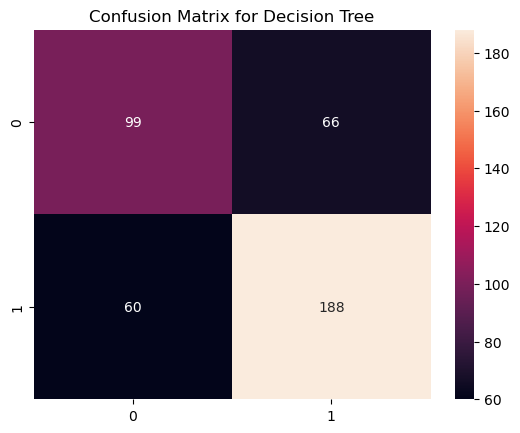

Accuracy: 0.6949152542372882
F1 Score: 0.749003984063745


In [46]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


# Step 3: Initialize and train the Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Step 4: Evaluate the Decision Tree classifier
y_pred = dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Decision Tree')
plt.show()



# Print Accuracy
accuracy = dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Average score for Fold 1: 0.7197
Average score for Fold 2: 0.7521
Average score for Fold 3: 0.7550
Average score for Fold 4: 0.7654
Average score for Fold 5: 0.8051
Best cross-validation score: 0.7816
Standard deviation of the best score: 0.0310
Best parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


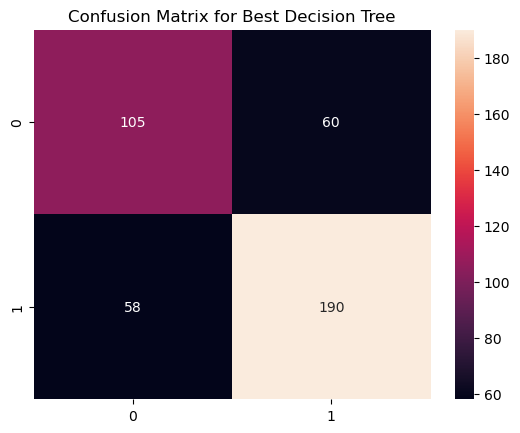

Precision: 0.7600
Recall: 0.7661
Accuracy: 0.7142857142857143
F1 Score: 0.7630522088353414
MCC: 0.40333135009329957


In [48]:
# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Initialize Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=dt, 
                          param_grid=param_grid,
                          cv=5,
                          scoring='f1',
                          n_jobs=-1,
                          verbose=1)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Access the cross-validation results
cv_results = grid_search.cv_results_

# Number of folds used in cross-validation
num_folds = grid_search.cv

# Initialize a list to store the cumulative scores for each fold
fold_scores = [0] * num_folds

# Sum the test scores for each fold across all parameter sets
for i in range(len(cv_results['params'])):
    for j in range(num_folds):
        fold_scores[j] += cv_results[f'split{j}_test_score'][i]

# Calculate the average score for each fold by dividing by the number of parameter sets
num_params = len(cv_results['params'])
avg_fold_scores = [score / num_params for score in fold_scores]

# Print the average score for each fold
for fold, score in enumerate(avg_fold_scores):
    print(f"Average score for Fold {fold + 1}: {score:.4f}")

# Extract the mean test scores and standard deviation of test scores
mean_test_scores = cv_results['mean_test_score']
std_test_scores = cv_results['std_test_score']

# Print the best score with its standard deviation
best_index = grid_search.best_index_
print(f"Best cross-validation score: {mean_test_scores[best_index]:.4f}")
print(f"Standard deviation of the best score: {std_test_scores[best_index]:.4f}")

# Print best parameters and score
print("Best parameters:", grid_search.best_params_)


# Get best model
best_dt = grid_search.best_estimator_

# Make predictions with best model
y_pred = best_dt.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix for Best Decision Tree')
plt.show()

# Calculate Precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision:.4f}')

# Calculate Recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall:.4f}')

# Print Accuracy
accuracy = best_dt.score(X_test, y_test)
print(f'Accuracy: {accuracy}')

# Calculate and print F1 Score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculate and print Matthews Correlation Coefficient (MCC)
mcc = matthews_corrcoef(y_test, y_pred)
print(f'MCC: {mcc}')